# Perceptual loudness comparison on noises

TLDR: this notebook calculates the attenuation (due to perceptually-motivated weigthing) on pink noise and real world noises.
The difference between these attenuation factors will be considered when picking an appropriate SNR level.


In [1]:
import os
import time
import sys
import librosa as lr
import librosa.display as lrd
import numpy as np
import pandas as pd
import json
import glob

import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import minmax_scale

%matplotlib inline

sys.path.append("..")
from libs.colored_noise import powerlaw_psd_gaussian
from libs.processing import pink_noise, take_file_as_noise, \
    make_fragments, unmake_fragments_slice


In [2]:
# real world noises
paths = glob.glob('/data/riccardo_datasets/demand/**/*.wav')
print(paths)

['/data/riccardo_datasets/demand/OMEETING/ch01.wav', '/data/riccardo_datasets/demand/PCAFETER/ch01.wav', '/data/riccardo_datasets/demand/PRESTO/ch01.wav', '/data/riccardo_datasets/demand/DKITCHEN/ch01.wav', '/data/riccardo_datasets/demand/STRAFFIC/ch01.wav', '/data/riccardo_datasets/demand/TCAR/ch01.wav', '/data/riccardo_datasets/demand/PSTATION/ch01.wav', '/data/riccardo_datasets/demand/OOFFICE/ch01.wav', '/data/riccardo_datasets/demand/DWASHING/ch01.wav', '/data/riccardo_datasets/demand/NFIELD/ch01.wav', '/data/riccardo_datasets/demand/SCAFE/ch01.wav', '/data/riccardo_datasets/demand/NPARK/ch01.wav', '/data/riccardo_datasets/demand/TBUS/ch01.wav', '/data/riccardo_datasets/demand/TMETRO/ch01.wav', '/data/riccardo_datasets/demand/SPSQUARE/ch01.wav', '/data/riccardo_datasets/demand/OHALLWAY/ch01.wav', '/data/riccardo_datasets/demand/DLIVING/ch01.wav', '/data/riccardo_datasets/demand/NRIVER/ch01.wav']


/home/rmicci18/miniconda3/envs/denoising/lib/python3.6/site-packages/librosa/core/time_frequency.py:1006: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3]))


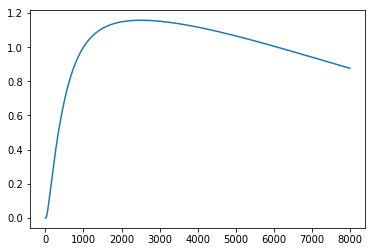

In [3]:
# calculate a-weights (how much each freq is attenuated)
_, sr = lr.load(paths[0], sr=None)
fft_f = lr.fft_frequencies(sr=sr)
aw = lr.db_to_amplitude(lr.A_weighting(fft_f))
plt.plot(fft_f, aw)

In [4]:
def get_weighted_sig(x):
    s = lr.stft(x)
    s_adj = (s.T*aw).T
    y = lr.istft(s_adj)
    return y

In [5]:
# attenuation on pink noise (dB)
xx = powerlaw_psd_gaussian(1, 60 * 5 * sr)
pp = xx.std()
yy = get_weighted_sig(xx)
pp_adj = yy.std()
attenuation_pink = lr.power_to_db([pp_adj / pp])[0]
print(attenuation_pink)


-3.424010463456689


## attenuation on pink noise: approx -3.5dB


In [6]:
# attenuation on real world noises (dB)
attenuations = {}
for path in paths:
    name = os.path.basename(os.path.dirname(path))
    x, _ = lr.load(path, sr=sr)
    p = x.std()
    y = get_weighted_sig(x)
    p_adj = y.std()
    attenuations[name] = lr.power_to_db([p_adj / p])[0]
    print(path, [p_adj / p], [str(attenuations[name]) + ' dB'])


/data/riccardo_datasets/demand/OMEETING/ch01.wav [0.55744386] ['-2.5379887 dB']
/data/riccardo_datasets/demand/PCAFETER/ch01.wav [0.4547493] ['-3.4222796 dB']
/data/riccardo_datasets/demand/PRESTO/ch01.wav [0.6984374] ['-1.5587252 dB']
/data/riccardo_datasets/demand/DKITCHEN/ch01.wav [0.34494093] ['-4.622553 dB']
/data/riccardo_datasets/demand/STRAFFIC/ch01.wav [0.26714778] ['-5.732485 dB']
/data/riccardo_datasets/demand/TCAR/ch01.wav [0.029713504] ['-15.270461 dB']
/data/riccardo_datasets/demand/PSTATION/ch01.wav [0.4057795] ['-3.917099 dB']
/data/riccardo_datasets/demand/OOFFICE/ch01.wav [0.045556653] ['-13.414482 dB']
/data/riccardo_datasets/demand/DWASHING/ch01.wav [0.034589965] ['-14.610499 dB']
/data/riccardo_datasets/demand/NFIELD/ch01.wav [0.073025234] ['-11.365271 dB']
/data/riccardo_datasets/demand/SCAFE/ch01.wav [0.3192397] ['-4.958831 dB']
/data/riccardo_datasets/demand/NPARK/ch01.wav [0.32799682] ['-4.841304 dB']
/data/riccardo_datasets/demand/TBUS/ch01.wav [0.04992506] ['

          attenuation  relative_attenuation       gain
OMEETING    -2.537989              0.886022  -0.886022
PCAFETER    -3.422280              0.001731  -0.001731
PRESTO      -1.558725              1.865285  -1.865285
DKITCHEN    -4.622553             -1.198542   1.198542
STRAFFIC    -5.732485             -2.308474   2.308474
TCAR       -15.270461            -11.846451  11.846451
PSTATION    -3.917099             -0.493089   0.493089
OOFFICE    -13.414482             -9.990472   9.990472
DWASHING   -14.610499            -11.186489  11.186489
NFIELD     -11.365271             -7.941260   7.941260
SCAFE       -4.958831             -1.534820   1.534820
NPARK       -4.841304             -1.417293   1.417293
TBUS       -13.016814             -9.592804   9.592804
TMETRO      -5.786309             -2.362299   2.362299
SPSQUARE    -7.396984             -3.972974   3.972974
OHALLWAY    -9.420412             -5.996402   5.996402
DLIVING     -4.948244             -1.524233   1.524233
NRIVER    

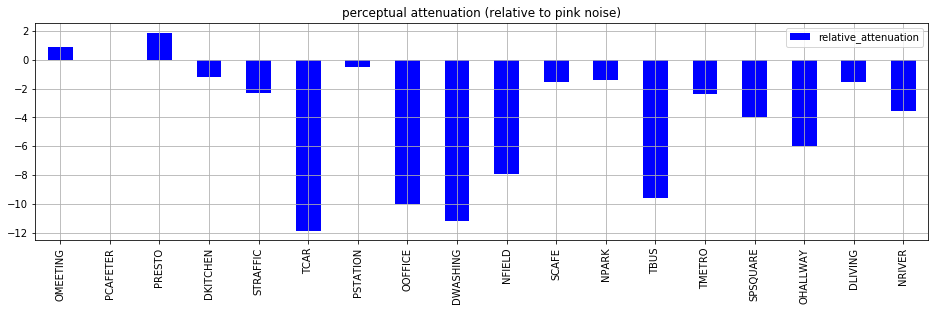

In [7]:
# put into dataframe
df = pd.DataFrame.from_dict(attenuations, orient='index', columns=['attenuation'])
# make relative to pink noise attenuation
df['relative_attenuation'] = df['attenuation'] - attenuation_pink
# make into gain factor
df['gain'] = -df['relative_attenuation']

# show the whole thing
df.plot.bar(y='relative_attenuation', color='b', grid=True, figsize=(16, 4), title='perceptual attenuation (relative to pink noise)')
print(df)

## as expected, when compared to pink noise, most noises are heavily attenuated (i.e. they sound much quieter than what their RMS figure claims)

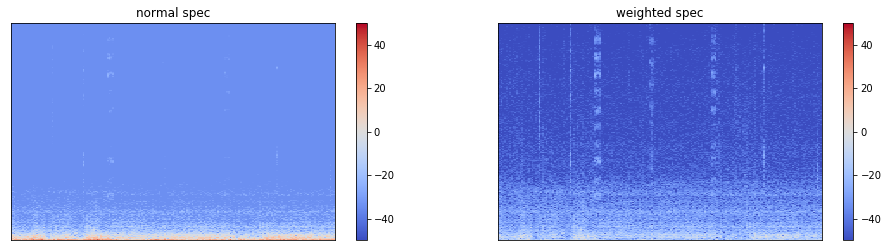

In [8]:
# manually inspect special cases
x, _ = lr.load('/data/riccardo_datasets/demand/TCAR/ch01.wav', sr=sr)
p = x.std()
plt.figure(figsize=(16, 4))

s = lr.stft(x)
plt.subplot(121)
lrd.specshow(lr.amplitude_to_db(np.abs(s[:,::50])), vmin=-50, vmax=50, cmap='coolwarm')
plt.colorbar()
plt.title('normal spec')

s_adj = (s.T*aw).T
plt.subplot(122)
lrd.specshow(lr.amplitude_to_db(np.abs(s_adj[:,::50])), vmin=-50, vmax=50, cmap='coolwarm')
plt.colorbar()
plt.title('weighted spec')

y = lr.istft(s_adj)
p_adj = y.std()


## why is TCAR attenuated by 12dB? Well, turns out most of the signal energy is in located in a frequency range that's perceptually not very loud.


In [9]:
# test results: mix a signal with pink noise and with real-world noise @ 0 dB SNR
noise_type = 'OMEETING'
SNR_dB = 0
x, sr = lr.load('/data/riccardo_datasets/npr_news/newscast220831.wav', sr=None, duration=10, offset=10)
bins = np.linspace(0, 3, 100) 

noise_file = '/data/riccardo_datasets/demand/{}/ch01.wav'.format(noise_type)
file_noise = take_file_as_noise(noise_file)

# play noise excerpt
xx, _ = lr.load(noise_file, sr=None, duration=10, offset=10)
ipd.Audio(xx, rate=sr)

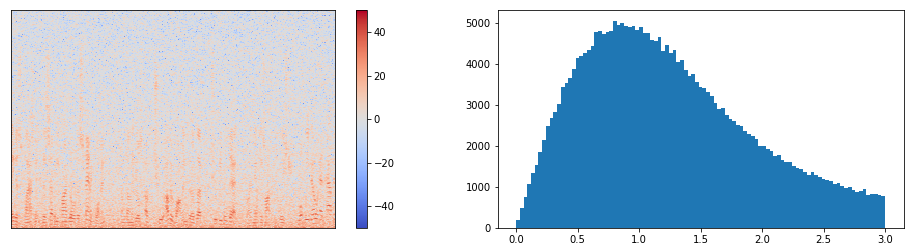

In [10]:
# mix with pink noise
xn_p = pink_noise(x=x, sr=sr, snr=SNR_dB)
s_p = lr.stft(xn_p)

plt.figure(figsize=(16, 4))
plt.subplot(121)
lrd.specshow(lr.amplitude_to_db(np.abs(s_p)), vmin=-50, vmax=50, cmap='coolwarm')
plt.colorbar()
plt.subplot(122)
counts, bins, bars = plt.hist(np.abs(s_p).flatten(), bins=bins)

ipd.Audio(xn_p, rate=sr)

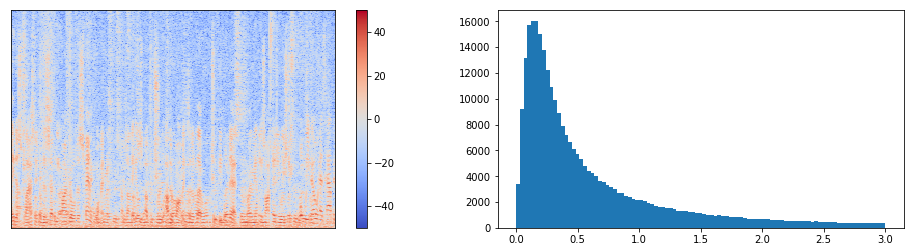

In [11]:
# mix with file noise (no compensation)
xn_f = file_noise(x=x, sr=sr, snr=SNR_dB)
s_f = lr.stft(xn_f)

plt.figure(figsize=(16, 4))
plt.subplot(121)
lrd.specshow(lr.amplitude_to_db(np.abs(s_f)), vmin=-50, vmax=50, cmap='coolwarm')
plt.colorbar()
plt.subplot(122)
counts, bins, bars = plt.hist(np.abs(s_f).flatten(), bins=bins)

ipd.Audio(xn_f, rate=sr)

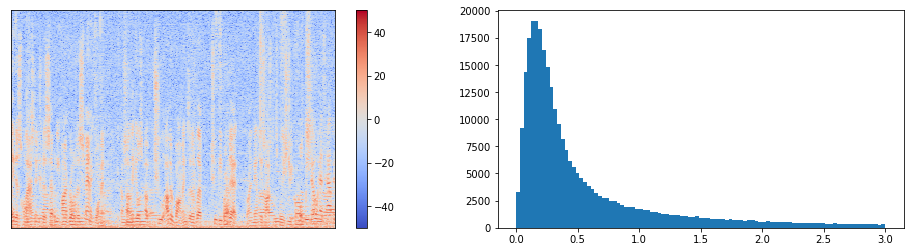

In [12]:
# mix with file noise (with compensation)
xn_f2 = file_noise(x=x, sr=sr, snr=SNR_dB-df['gain'][noise_type])
s_f2 = lr.stft(xn_f2)

plt.figure(figsize=(16, 4))
plt.subplot(121)
lrd.specshow(lr.amplitude_to_db(np.abs(s_f2)), vmin=-50, vmax=50, cmap='coolwarm')
plt.colorbar()
plt.subplot(122)
counts, bins, bars = plt.hist(np.abs(s_f2).flatten(), bins=bins)

ipd.Audio(xn_f2, rate=sr)

## sounds good, no? now, while we're at it...

_____

# determining bandwidth of real-world noise 

TLDR: here we determine how much of the available bandwidth (20-8000 hz) each signal is using.
Noise signals will be divided into "broad-band" and "narrow-band", for the sake of ensuring an equald distribution of noise characteristics across training and testing sets.

In [13]:
# spectral bandwidth on real world noises (dB)
bandwidths = {}
for path in paths:
    name = os.path.basename(os.path.dirname(path))
    x, _ = lr.load(path, sr=sr)
    #lr.display.waveplot(x, sr=sr, alpha=0.4)
    bw2 = lr.feature.spectral_bandwidth(x+0.01, sr=sr, p=2)[0]
    #t = lr.times_like(bw2, sr=sr)
    #plt.plot(t, normalize(spectral_bandwidth_2), color='r')
    bandwidths[name] = bw2
    print(name, len(bw2), bw2.mean())


OMEETING 9376 1563.4266276314163
PCAFETER 9376 1810.4410461981267
PRESTO 9376 2075.303042661304
DKITCHEN 9376 2772.9256600633253
STRAFFIC 9376 1844.0874355423518
TCAR 9376 654.8313490697776
PSTATION 9376 1681.9209442703454
OOFFICE 9376 1501.0606541358181
DWASHING 9376 1397.3861501102874
NFIELD 9376 1268.0896901976992
SCAFE 9376 1746.6234981874964
NPARK 9376 1803.29412391461
TBUS 9376 1547.3642845865477
TMETRO 9376 1701.8706205143678
SPSQUARE 9376 1565.9187743804323
OHALLWAY 9376 1453.2778332696794
DLIVING 9376 1565.4150952260027
NRIVER 9376 1772.191619343778


In [14]:
# store as dataframe
df2 = pd.DataFrame.from_dict(bandwidths, orient='index').T

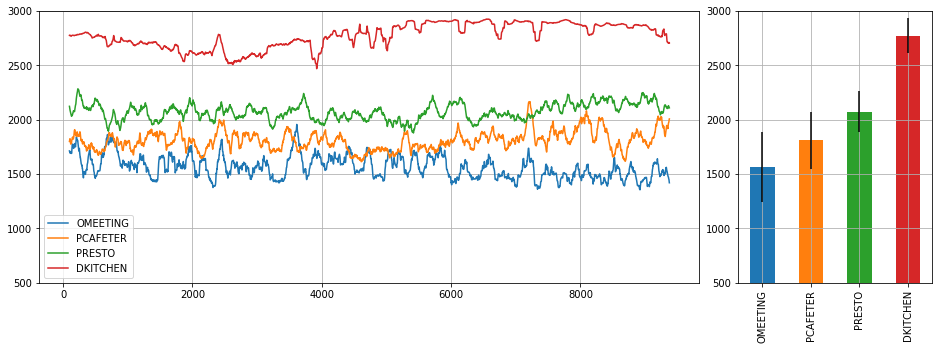

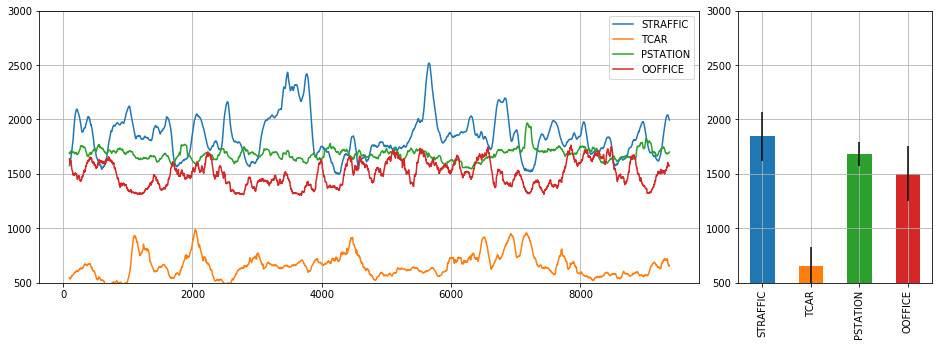

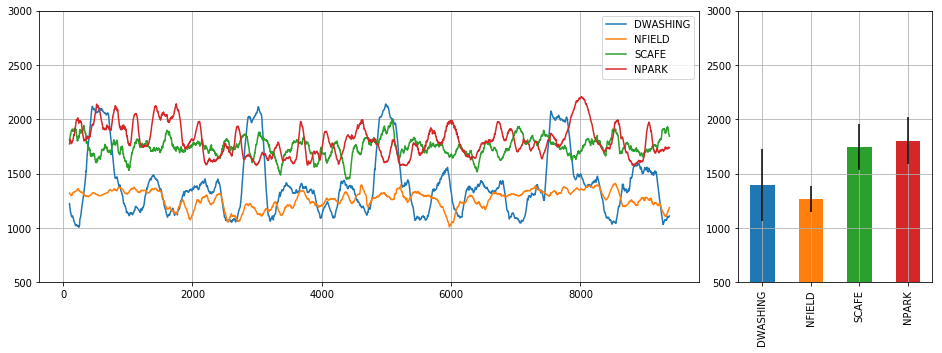

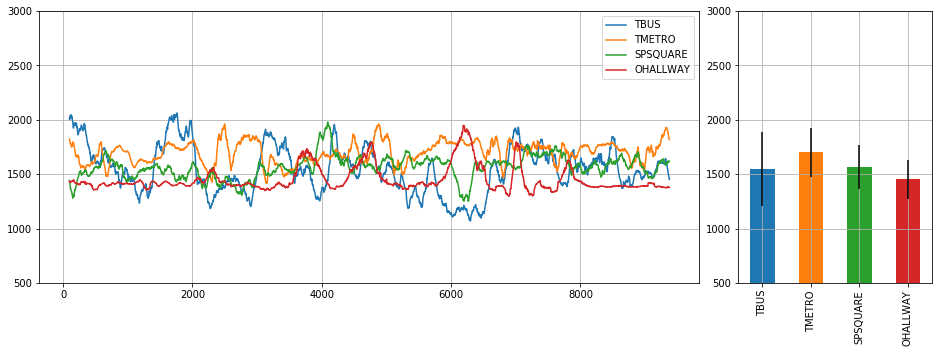

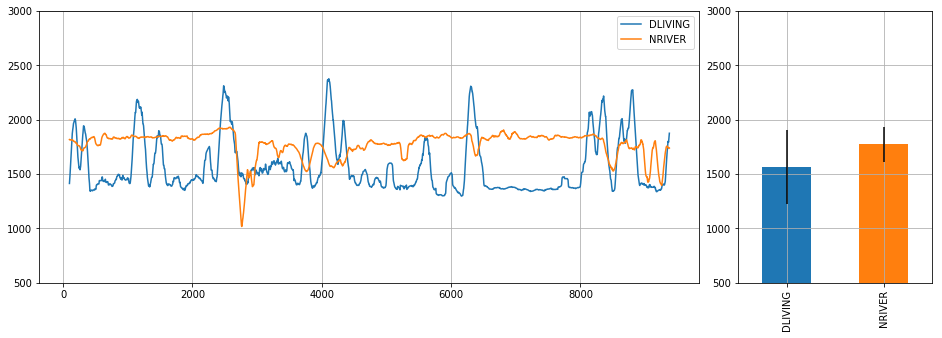

In [15]:
# and view it all!
n = 4
ylims = (500,3000)
for i in range(int(np.ceil(df2.shape[1]/n))):
    sl = slice(i*n, (i+1)*n)
    fig = plt.figure(figsize=(16, 5))
    ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
    df2.iloc[:,sl].rolling(100).mean().dropna().plot(ax=ax1, grid=True, ylim=ylims)
    ax2 = plt.subplot2grid((1, 4), (0, 3))
    df2.iloc[:,sl].mean().plot.bar(ax=ax2, grid=True, yerr=df2.iloc[:,sl].std(), ylim=ylims)

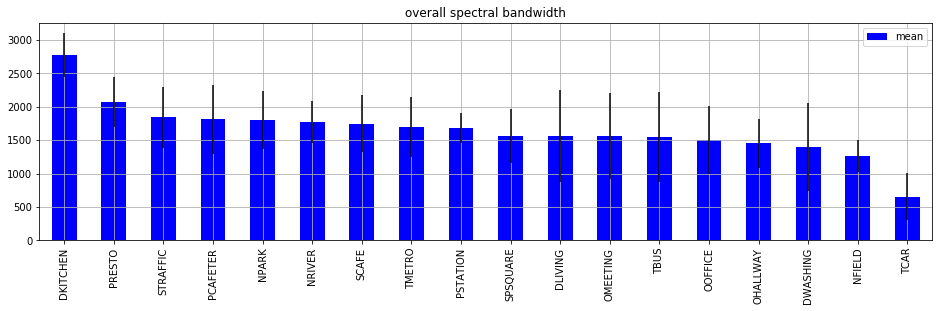

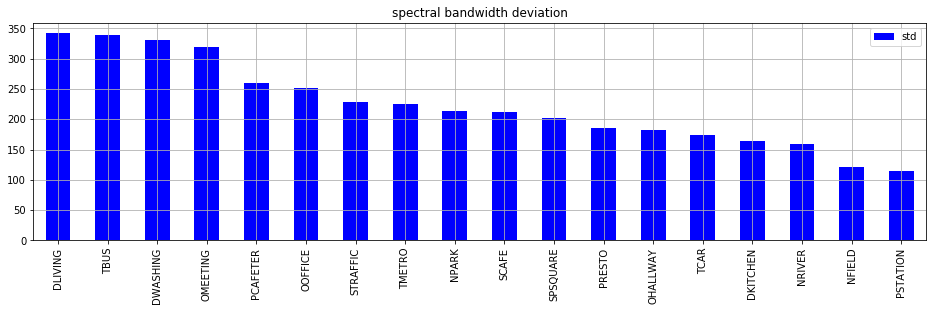

In [16]:
# lots of data, let's just plot it 
#   sorted by the overall mean bandwith (and error bars)
df3 = pd.DataFrame({
    'mean': df2.mean(),
    'std':  df2.std(),
    'err':  df2.std()*2
})

df3.sort_values('mean', ascending=False).plot.bar(
    y='mean', yerr='err', color='b', grid=True, figsize=(16, 4), title='overall spectral bandwidth')

df3.sort_values('std', ascending=False).plot.bar(
    y='std', color='b', grid=True, figsize=(16, 4), title='spectral bandwidth deviation')


## time for validating/inspecting findings

In [17]:
def plot_spec(noise_type, duration):
    x, _ = lr.load('/data/riccardo_datasets/demand/{}/ch01.wav'.format(noise_type), sr=sr, duration=duration, offset=duration/2)
    s = lr.stft(x)
    plt.figure(figsize=(16, 2))
    lrd.specshow(lr.amplitude_to_db(np.abs(s)), vmin=-40, vmax=40, cmap='coolwarm')
    plt.colorbar()
    plt.title(noise_type)

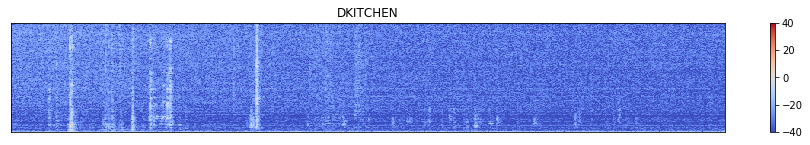

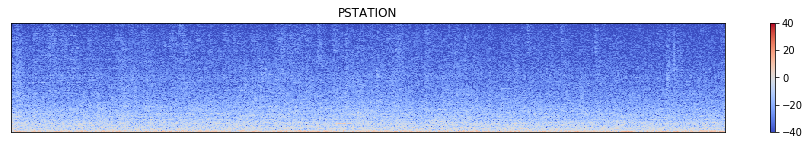

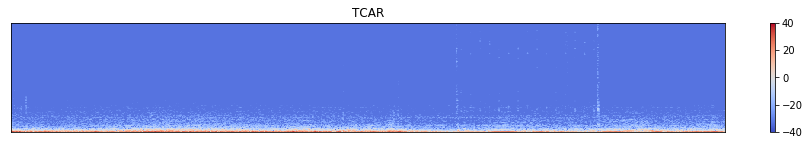

In [18]:
# seems like 'DKITCHEN' and 'TCAR' have some pretty extreme bandwidths
plot_spec('DKITCHEN', 30)
plot_spec('PSTATION', 30) # median, for comparison
plot_spec('TCAR', 30)
# makes sense! (bandwidths are noticeably different)

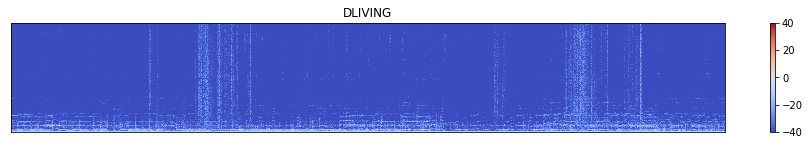

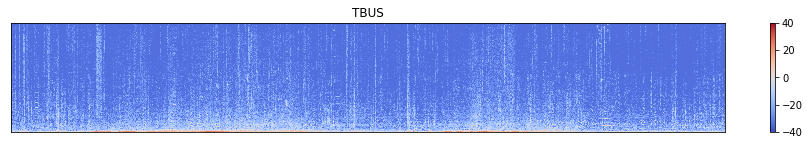

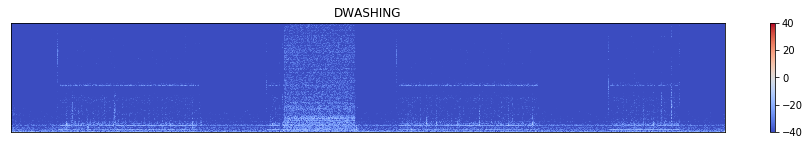

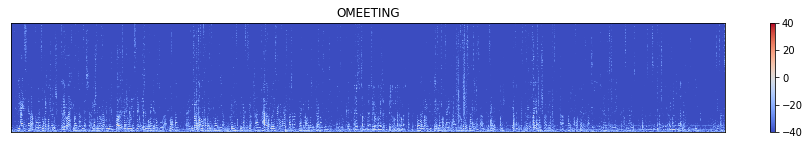

In [19]:
# these noises vary a lot over time, let's check a long fragment
plot_spec('DLIVING', 100)
plot_spec('TBUS', 100) 
plot_spec('DWASHING', 100)
plot_spec('OMEETING', 100)
# makes sense! (lots of transients etc)

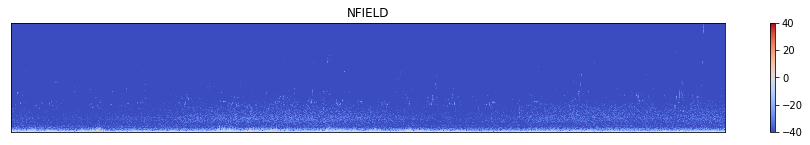

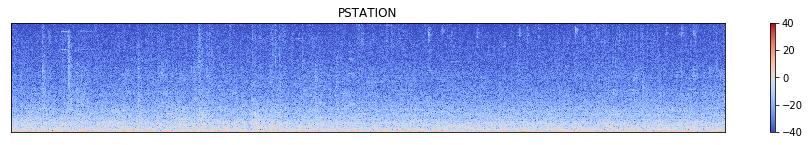

In [20]:
# these don't seem to vary much, let's also check a long fragment
plot_spec('NFIELD', 100) 
plot_spec('PSTATION', 100)
# makes sense! (pretty stationary-looking)

## so, those numbers were not lying. let's classify them with a D&D alignment chart (a scatterplot)

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# add a color and size columns
colormap = cm.rainbow
markers = {
    'D': 'o',
    'N': 'o',
    'O': 's',
    'P': 's',
    'S': '^',
    'T': '^',
}
df3 = df3.sort_index()
df3['col'] = [colors.rgb2hex(colormap(i % 6 / 6)) for i in range(len(df3))]
df3['marker'] = [markers[i[0]] for i in df3.index]


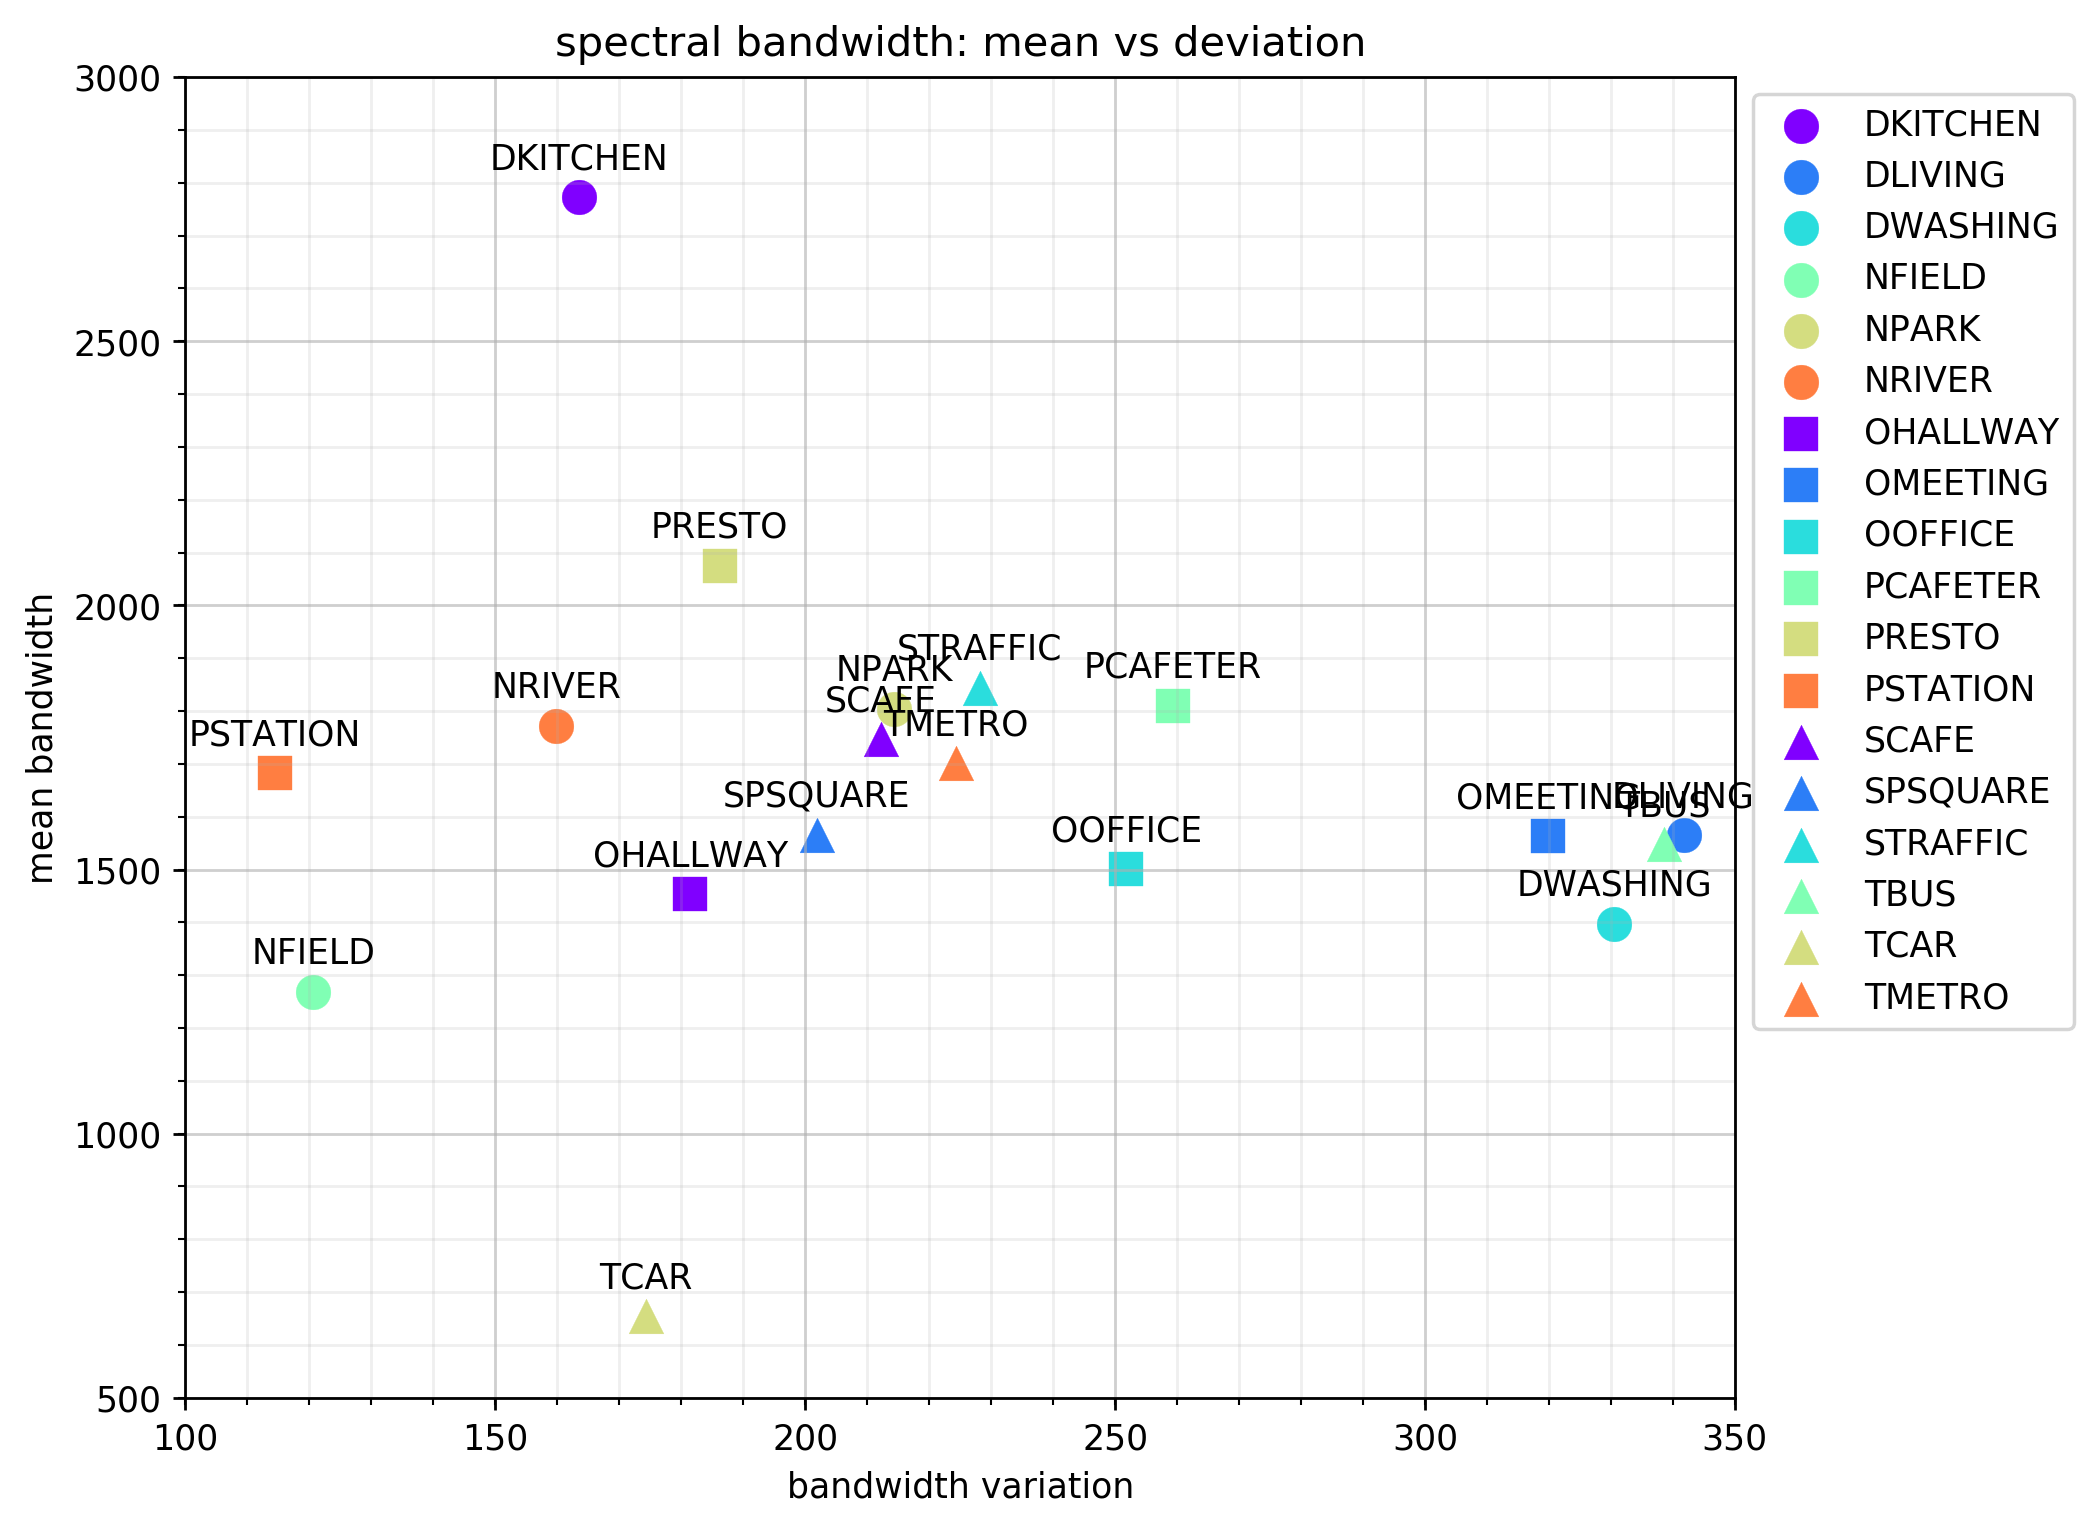

In [22]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=250)
# plot dots, one at a time
for i, row in df3.iterrows():
    x = row['std']
    y = row['mean']
    c = row['col']
    m = row['marker']
    l = i
    ax.scatter(x, y, label=l, s=100, marker=m, linewidth=0.1, c=c)
    ax.text(x, y+40, l, horizontalalignment='center', verticalalignment='bottom')

# plot formatting
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title('spectral bandwidth: mean vs deviation')
plt.xlabel('bandwidth variation')
plt.ylabel('mean bandwidth')
xlims = (100, 350.1)
ylims = (500, 3001)
plt.ylim(ylims)
plt.xlim(xlims)
ax.set_xticks(np.arange(*xlims, 50))
ax.set_xticks(np.arange(*xlims, 10), minor=True)
ax.set_yticks(np.arange(*ylims, 500))
ax.set_yticks(np.arange(*ylims, 100), minor=True)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

## the data doesn't seem to be spread out evenly but whatevs... 
## let's construct a nice data structure with all the infos

In [23]:
# thresholds
thrs_stationarity = 200
thrs_wideband = 1500

In [25]:
# sort all dataframes
df.sort_index(inplace=True)
df3.sort_index(inplace=True)

# put together the useful infos
df4 = pd.DataFrame()
df4['gain'] = -df['attenuation']
df4['bw_std'] = df3['std']
df4['bw_mean'] = df3['mean']
df4['filepath'] = ['/data/riccardo_datasets/demand/{}/ch01.wav'.format(i) for i in df.index]

# into a dict
_rwnoises = df4.to_dict(orient='index')

## let's make a function to extract the desired noises

In [26]:
_pinknoise_gain = 3.5
thrs_std = 200      # threshold for stationary
thrs_mean = 1500    # threshold for narrowband

def get_rwnoises(stationary='both', narrowband='both'):
    noises = {}
    # filter by stationarity (bw std)
    for i in _rwnoises:
        if stationary == 'both':
            noises[i] = _rwnoises[i]
        elif stationary == True and _rwnoises[i]['bw_std'] < thrs_std:
            noises[i] = _rwnoises[i]
        elif stationary == False and _rwnoises[i]['bw_std'] > thrs_std:
            noises[i] = _rwnoises[i]
            
    noises2 = {}
    # filter by bandwidth (bw mean)
    for i in noises:
        if narrowband == 'both':
            noises2[i] = _rwnoises[i]
        elif narrowband == True and _rwnoises[i]['bw_mean'] < thrs_mean:
            noises2[i] = _rwnoises[i]
        elif narrowband == False and _rwnoises[i]['bw_mean'] > thrs_mean:
            noises2[i] = _rwnoises[i]
            
    # extract useful infos only
    noises_list = [{'filepath': noises2[i]['filepath'], 'gain': noises2[i]['gain']-_pinknoise_gain} for i in noises2]
    # return only the desired amount
    return noises_list

In [27]:
# test it out!
from pprint import pprint
#pprint(get_rwnoises())
#pprint(get_rwnoises(stationary=True))
pprint(get_rwnoises(stationary=True, narrowband=True))


[{'filepath': '/data/riccardo_datasets/demand/NFIELD/ch01.wav',
  'gain': 7.865270614624023},
 {'filepath': '/data/riccardo_datasets/demand/OHALLWAY/ch01.wav',
  'gain': 5.920412063598633},
 {'filepath': '/data/riccardo_datasets/demand/TCAR/ch01.wav',
  'gain': 11.770461082458496}]


In [31]:
rwnoises = []
rwnoises.append(get_rwnoises(stationary=True, narrowband=True)[0])
rwnoises.append(get_rwnoises(stationary=True, narrowband=False)[:2])
pprint(rwnoises)

[{'filepath': '/data/riccardo_datasets/demand/NFIELD/ch01.wav',
  'gain': 7.865270614624023},
 [{'filepath': '/data/riccardo_datasets/demand/DKITCHEN/ch01.wav',
   'gain': 1.1225528717041016},
  {'filepath': '/data/riccardo_datasets/demand/NRIVER/ch01.wav',
   'gain': 3.499195098876953}]]


In [38]:
rwnoises = []
rwnoises += [get_rwnoises(stationary=True, narrowband=True)[-1]]
rwnoises += get_rwnoises(stationary=True, narrowband=False)[-3:-1]
pprint(rwnoises)

[{'filepath': '/data/riccardo_datasets/demand/TCAR/ch01.wav',
  'gain': 11.770461082458496},
 {'filepath': '/data/riccardo_datasets/demand/NRIVER/ch01.wav',
  'gain': 3.499195098876953},
 {'filepath': '/data/riccardo_datasets/demand/PRESTO/ch01.wav',
  'gain': -1.9412747621536255}]


In [41]:
print(get_rwnoises(stationary=True, narrowband=True)[0])      # seen
print(get_rwnoises(stationary=True, narrowband=True)[-1])     # unseen
print(get_rwnoises(stationary=True, narrowband=False)[0])     # seen
print(get_rwnoises(stationary=True, narrowband=False)[-1])    # unseen

{'filepath': '/data/riccardo_datasets/demand/NFIELD/ch01.wav', 'gain': 7.865270614624023}
{'filepath': '/data/riccardo_datasets/demand/TCAR/ch01.wav', 'gain': 11.770461082458496}
{'filepath': '/data/riccardo_datasets/demand/DKITCHEN/ch01.wav', 'gain': 1.1225528717041016}
{'filepath': '/data/riccardo_datasets/demand/PSTATION/ch01.wav', 'gain': 0.4170989990234375}
